---
title: "From Score Matching to Diffusion Models"
author: "Mark Fuge"
date: "November 9th, 2025"
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In the previous chapter, we introduced Denoising Score Matching (DSM) as a way to learn a generative vector field, the **score function** $\nabla_x \log p(x)$, without the computationally expensive trace term that plagued Continuous Normalizing Flows. We used this learned score to generate samples via Langevin Dynamics, which follows the score field uphill while adding noise to explore the data distribution.

However, this approach has its own limitations. The score function is only well-defined and easy to learn *near* the data. Far from the data manifold, where there are no samples, the score can be chaotic or undefined, making it difficult to initialize a generative process from random noise. Furthermore, we had to choose a single, fixed noise level $\sigma$ for training, which created a trade-off: too much noise and we lose important details; too little and the score is hard to learn.

This chapter introduces **Diffusion Models**, which solve these problems by learning a score function not just for one noise level, but for a *continuum* of noise levels. This creates a robust, time-dependent vector field that can smoothly transform pure noise into structured data.

## Learning Objectives

By the end of this notebook, you should have a strong intuition for:

- Why diffusion models can be seen as “time-extended” score models.
- How the **forward process** gradually adds noise to data, creating a series of tractable distributions.
- How the **reverse process** uses a time-conditional score model to denoise a sample back onto the data manifold.
- How noise levels ($t$) structure the learning problem and stabilize training.
- How to implement and train a simple diffusion model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.optim as optim
from gen_models_utilities import create_ring_gaussians, make_loader
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Use a consistent style
plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

# for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = "cpu"
print(f'Using device: {device}')

data, _ = create_ring_gaussians(n_samples=5000)

Using device: cpu


## Why Go Beyond Single-Noise Score Matching?

Let's first revisit the limitations of the score model we trained in the previous chapter. That model learned the score function for a *single* noise level, $\sigma$. This meant trading off detail and stability: a small $\sigma$ captures fine details but is hard to learn, while a large $\sigma$ smooths out the data but loses the ability to describe higher-frequency contours of the true log probability.

The key idea behind diffusion models is that they fix this problem by defining a continuum of noisy data distributions $p_t(x)$, which are smooth and well-behaved everywhere, even far from the data, yet can still create score functions that capture fine details when $t$ is small.

In [2]:
# Define the same ScoreNet2D from the previous notebook
class ScoreNet2D(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Softplus(),
            nn.Linear(hidden, hidden),
            nn.Softplus(),
            nn.Linear(hidden, hidden),
            nn.Softplus(),
            nn.Linear(hidden, 2)
        )

    def forward(self, x):
        return self.net(x)

# This is a simplified training function from the previous notebook
def train_simple_score_net(sigma=0.5):
    
    loader = make_loader(data, batch_size=256)
    score_net = ScoreNet2D().to(device)
    optimizer = optim.AdamW(score_net.parameters(), lr=1e-3)
    for epoch in range(1000): # Train for fewer epochs for speed
        for (x,) in loader:
            x = x.to(device)
            noise = torch.randn_like(x) * sigma
            x_tilde = x + noise
            predicted_score = score_net(x_tilde)
            target_score = -noise / (sigma**2)
            loss = ((predicted_score - target_score)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print(f"Finished training score network with sigma={sigma}")
    return score_net, data

# Train a score network with a medium noise level
noise_level = 0.1
score_net_simple, data = train_simple_score_net(sigma=noise_level)


Finished training score network with sigma=0.1


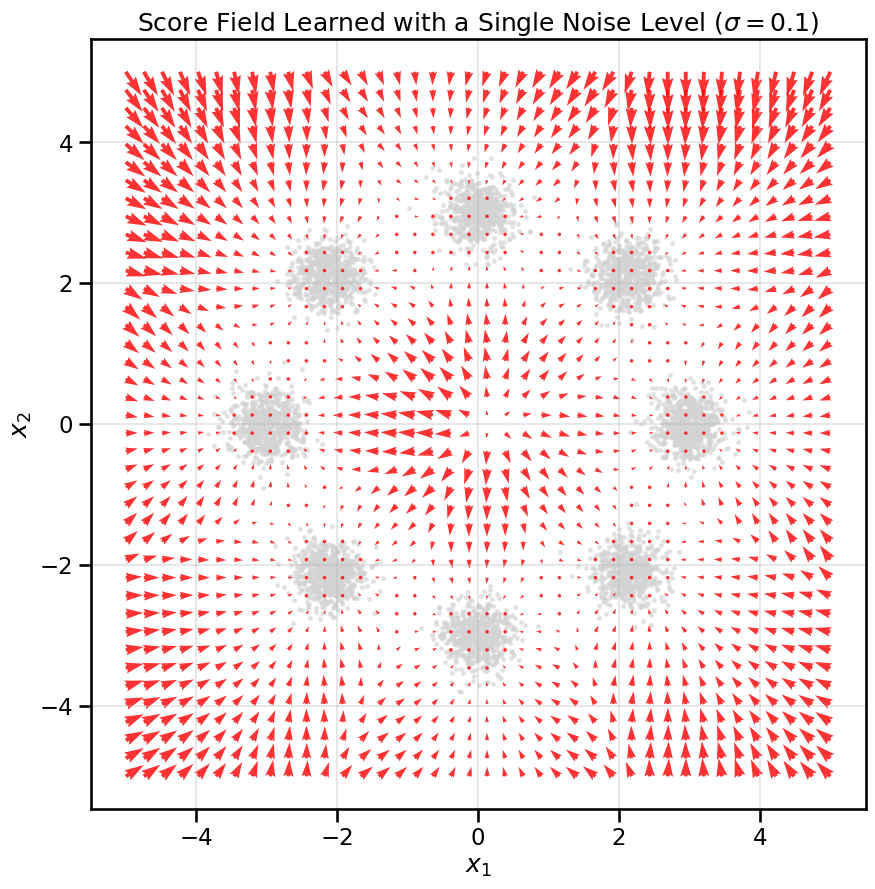

In [3]:

# Create a grid to visualize the score field
xx, yy = np.meshgrid(np.linspace(-5, 5, 40), np.linspace(-5, 5, 40))
grid_points = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32, device=device)

# Get the score at each grid point
score_net_simple.eval()
with torch.no_grad():
    scores = score_net_simple(grid_points).cpu().numpy()

# Plot the results
plt.figure(figsize=(10, 10))
#sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="viridis", fill=True, alpha=0.5, levels=20)
plt.scatter(data[:, 0], data[:, 1], s=5, color='lightgrey', alpha=0.5)
plt.quiver(grid_points[:, 0].cpu(), grid_points[:, 1].cpu(), scores[:, 0], scores[:, 1], color='red', width=0.005, alpha=0.8)
plt.title(f"Score Field Learned with a Single Noise Level ($\sigma={noise_level}$)")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

## The Forward Diffusion Process $q(x_t|x_0)$

The first key component of a diffusion model is the **forward process**, where we systematically destroy the structure in our data by gradually adding Gaussian noise over a series of timesteps. We define a "noise schedule" that controls how much noise is added at each step.

Let $x_0$ be a sample from our data distribution. The forward process $q(x_t|x_0)$ defines a noisy version of this sample at time $t$:

$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I) $$

Here, $\bar{\alpha}_t$ is a parameter that goes from 1 down to (almost) 0 as $t$ goes from 0 to $T$. 
- When $t=0$, $\bar{\alpha}_0 = 1$, so $x_0$ is just the original data.
- As $t$ increases, $\bar{\alpha}_t$ decreases, and more noise is added.
- When $t=T$ is large, $\bar{\alpha}_T \approx 0$, so $x_T$ is almost pure Gaussian noise.

This process creates a family of intermediate, noisy distributions $p_t(x)$. Let's visualize this by taking our ring of Gaussians and applying the forward process for different values of $t$.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


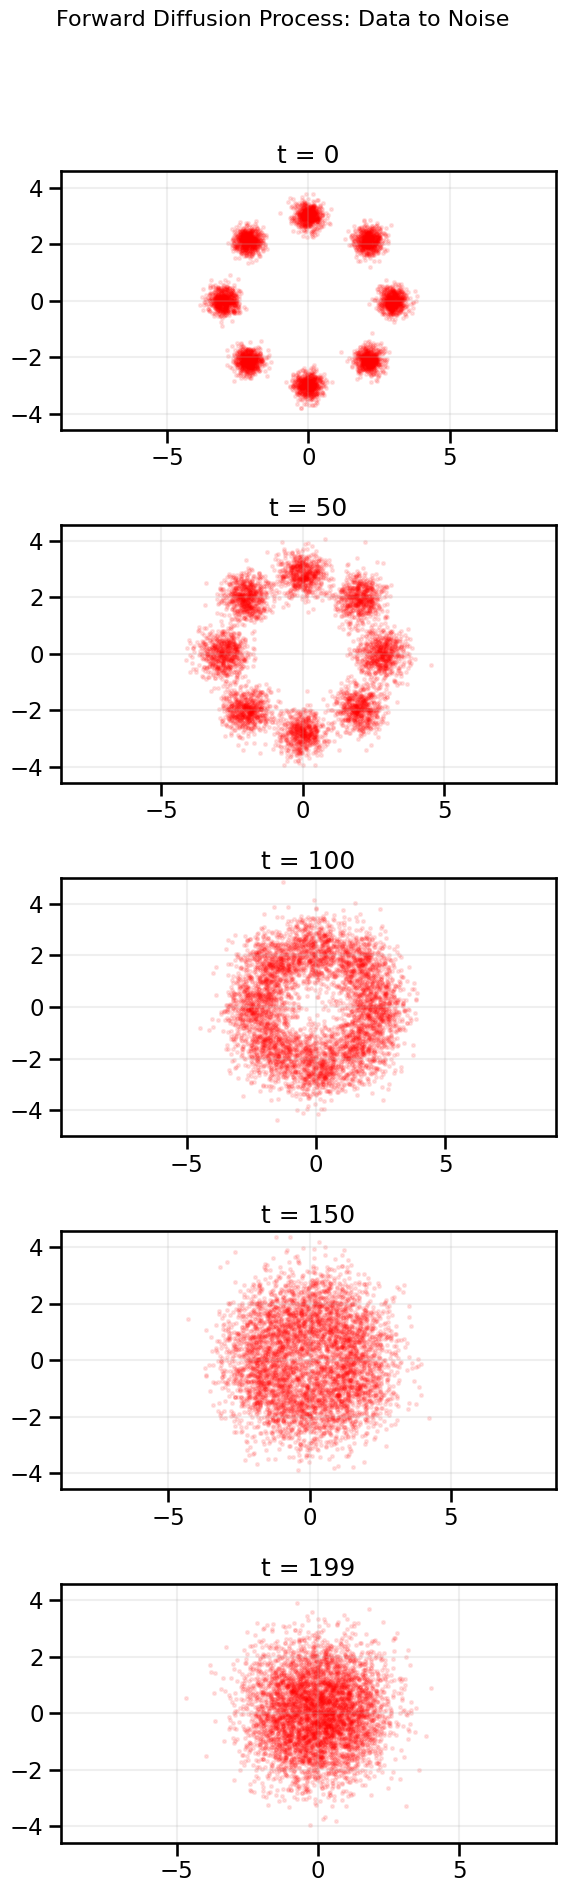

In [4]:
#| code-fold: false
def get_alphas(timesteps=1000, beta_start=0.0001, beta_end=0.02):
    """Create the noise schedule parameters alpha and alpha_bar."""
    betas = torch.linspace(beta_start, beta_end, timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    return alphas, alphas_cumprod

def forward_diffusion_sample(x_0, t, alphas_cumprod, device="cpu"):
    """Takes an datapoint and a timestep and returns the noisy version."""
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None]
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod[t])[:, None]
    
    # send to device
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.to(device)
    noise = noise.to(device)

    # Equation for x_t
    noisy_x = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy_x, noise

# Get the noise schedule
T = 200
alphas, alphas_cumprod = get_alphas(timesteps=T)

# Visualize the forward process
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

fig, axes = plt.subplots(5, 1, figsize=(6, 20))
plot_times = [0, T//4, T//2, 3*T//4, T-1]

for i, t_int in enumerate(plot_times):
    t = torch.full((data_tensor.shape[0],), t_int, dtype=torch.long)
    noisy_data, _ = forward_diffusion_sample(data_tensor, t, alphas_cumprod, device=device)
    noisy_data = noisy_data.cpu().numpy()
    
    ax = axes[i]
    ax.scatter(noisy_data[:, 0], noisy_data[:, 1], s=5, alpha=0.1, color="red")
    ax.set_title(f"t = {t_int}")
    ax.axis('equal')
    #ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.grid(True, alpha=0.2)

fig.suptitle("Forward Diffusion Process: Data to Noise", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As you can see, the forward process gradually transforms the structured ring of Gaussians into a fuzzy, isotropic Gaussian blob. At each intermediate step $t$, we have a distribution $p_t(x)$ that is smoother and more spread out than the original data distribution. This gives us a family of intermediate densities where score estimation is much easier and better-behaved, which is the key insight we will leverage next.

## The Reverse Process and Multi-Scale Score Estimation

The magic of diffusion models lies in the **reverse process**. If we can reverse the arrow of time, we can start from pure noise $x_T \sim \mathcal{N}(0, I)$ and gradually denoise it step-by-step to generate a clean sample $x_0$.

It turns out that the reverse of the diffusion process is also a diffusion, described by a stochastic differential equation (SDE). While the full derivation is beyond our scope, the key insight is that the "drift" of this reverse process depends on the score of the noisy data distribution at that time, $\nabla_{x_t} \log p_t(x_t)$.

$$
dx_t = f(x_t, t) dt + g(t)^2 \nabla_{x_t} \log p_t(x_t) dt + g(t) d\bar{W}_t
$$

where $f(x_t, t)$ is the drift term of the forward process, $g(t)$ is the diffusion coefficient, and $d\bar{W}_t$ is a Wiener process in reverse time. For the time being, lets put aside the exact forms of $f$ and $g$ and focus on the score term.


This is the crucial connection: **to reverse the diffusion, we need to know the score function at every noise level $t$**. This is why diffusion models are essentially **time-conditional score models**. Instead of learning a single score function for a fixed $\sigma$, we will learn a single neural network $s_\theta(x_t, t)$ that can estimate the score for any noisy sample $x_t$ at any time $t$.

Let's visualize what these score fields look like at different noise levels. We'll train separate score networks for low, medium, and high noise to see how the target vector field changes.

- **Low Noise (t is small):** The score field should be sharp and detailed, pointing strongly towards the modes of the original data.
- **Medium Noise (t is medium):** The score field will be smoother, capturing the global structure of the data (the ring) rather than individual modes.
- **High Noise (t is large):** The data is almost pure noise, so the score field will be largely diffuse, with weak gradients pointing towards the center of the distribution.

In [11]:
#| code-fold: false
# Map t to sigma. The variance of the noise added at time t is 1 - alpha_bar_t.
# So, sigma_t = sqrt(1 - alpha_bar_t)
T = 200
_, alphas_cumprod = get_alphas(timesteps=T)

# Times and corresponding sigmas to visualize
viz_times = {'Low Noise (t=10)': 2, 'Medium Noise (t=80)': 80, 'High Noise (t=199)': 199}
score_nets = {}
data_vis = None

for name, t_int in viz_times.items():
    sigma_t = torch.sqrt(1. - alphas_cumprod[t_int]).item()
    print(f"Training for {name}, sigma={sigma_t:.3f}")
    net, data_vis = train_simple_score_net(sigma=sigma_t)
    score_nets[name] = net

Training for Low Noise (t=10), sigma=0.024
Finished training score network with sigma=0.024492062628269196
Training for Medium Noise (t=80), sigma=0.532
Finished training score network with sigma=0.5321973562240601
Training for High Noise (t=199), sigma=0.932
Finished training score network with sigma=0.9315670728683472


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


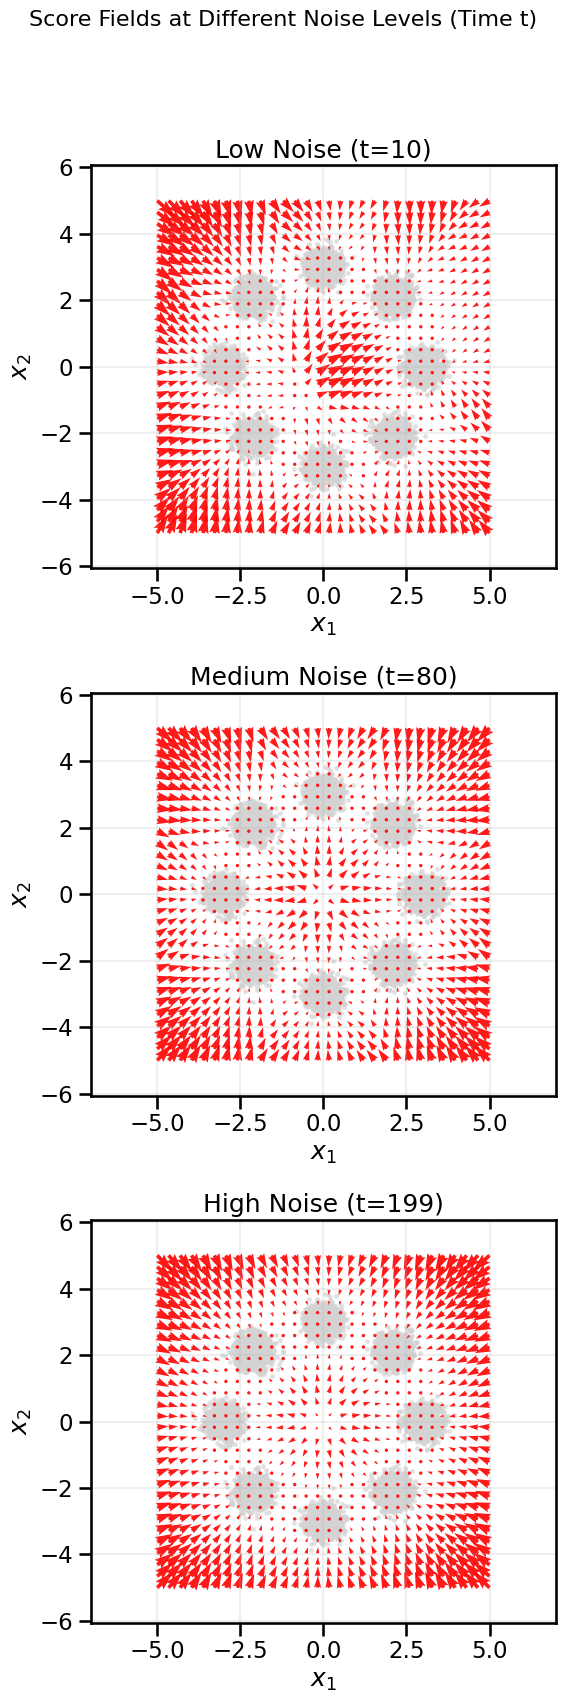

In [12]:

# Create a grid for visualization
xx, yy = np.meshgrid(np.linspace(-5, 5, 30), np.linspace(-5, 5, 30))
grid_points = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32, device=device)

# Plot the score fields
fig, axes = plt.subplots(3, 1, figsize=(6, 18))
for i, (name, net) in enumerate(score_nets.items()):
    net.eval()
    with torch.no_grad():
        scores = net(grid_points).cpu().numpy()
    
    ax = axes[i]
    #sns.kdeplot(x=data_vis[:, 0], y=data_vis[:, 1], cmap="viridis", fill=True, alpha=0.5, ax=ax, levels=20)
    ax.scatter(data_vis[:, 0], data_vis[:, 1], s=5, color='lightgrey', alpha=0.5)
    ax.quiver(grid_points[:, 0].cpu(), grid_points[:, 1].cpu(), scores[:, 0], scores[:, 1], color='red', width=0.008, alpha=0.9)
    ax.set_title(name)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('equal')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.grid(True, alpha=0.2)

fig.suptitle("Score Fields at Different Noise Levels (Time t)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## How Training Works (Denoising Score Matching Perspective)

Now that we understand the goal—learning a time-conditional score function—how do we train such a model? The answer is a natural extension of the Denoising Score Matching (DSM) objective we learned in the previous chapter.

Instead of training on a single noise level, we train on **all noise levels simultaneously**. We'll create a single neural network, $s_\theta(x_t, t)$, that takes both the noisy data $x_t$ and the timestep $t$ as input. The network's job is to predict the score of the noisy data distribution $p_t(x)$ at that specific time.

The loss function is almost identical to the one for simple DSM from last chapter, but now we take the expectation over uniformly sampled time $t$ as well:

$$
L(\theta) = \mathbb{E}_{x_0 \sim p_{data}, t \sim \text{Uniform}(0, T), \epsilon \sim \mathcal{N}(0, I)} \left[ \left\| s_\theta(x_t, t) - \nabla_{x_t} \log p_t(x_t | x_0) \right\|^2 \right]
$$

Just like before, the target score $\nabla_{x_t} \log p_t(x_t | x_0)$ is analytically known and simplifies to $-\frac{\epsilon}{\sqrt{1 - \bar{\alpha}_t}}$. So, our practical loss becomes:

$$
L(\theta) = \mathbb{E}_{x_0, t, \epsilon} \left[ \left\| s_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t) + \frac{\epsilon}{\sqrt{1 - \bar{\alpha}_t}} \right\|^2 \right]
$$

In many modern diffusion model implementations, it's more common to reparameterize the network to predict the noise $\epsilon$ directly, rather than the score. Let's call this network $\epsilon_\theta(x_t, t)$. The relationship is:
$s_\theta(x_t, t) = -\frac{\epsilon_\theta(x_t, t)}{\sqrt{1 - \bar{\alpha}_t}}$. Substituting this into the loss function gives a simpler, more stable objective:

$$
L(\theta) = \mathbb{E}_{x_0, t, \epsilon} \left[ \left\| \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t) - \epsilon \right\|^2 \right]
$$

This is (again) just a simple L2 regression! The network takes a noisy sample $x_t$ and its corresponding time $t$ and learns to predict the exact noise $\epsilon$ that was added to the original sample $x_0$.

### The Training Pipeline

The training process looks like this for each step:

1.  **Sample Data:** Pick a clean sample $x_0$ from the training data (our ring of Gaussians).
2.  **Sample Time:** Pick a random timestep $t$ uniformly from $\{0, 1, ..., T-1\}$.
3.  **Add Noise:** Create the noisy sample $x_t$ using the forward process equation: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.
4.  **Predict Noise:** Feed $x_t$ and $t$ into the neural network $\epsilon_\theta(x_t, t)$ to get the predicted noise.
5.  **Compute Loss:** Calculate the Mean Squared Error between the network's prediction and the true noise $\epsilon$.
6.  **Update:** Backpropagate the loss and update the network's weights.

By repeating this process, the single network $\epsilon_\theta$ learns the entire time-varying vector field.

Epoch 0, Loss: 0.9584
Epoch 50, Loss: 0.6565
Epoch 100, Loss: 0.6203
Epoch 150, Loss: 0.6269
Epoch 200, Loss: 0.5734
Epoch 250, Loss: 0.5667
Epoch 300, Loss: 0.5323
Epoch 350, Loss: 0.5374
Epoch 400, Loss: 0.5166
Epoch 450, Loss: 0.5259
Training complete.


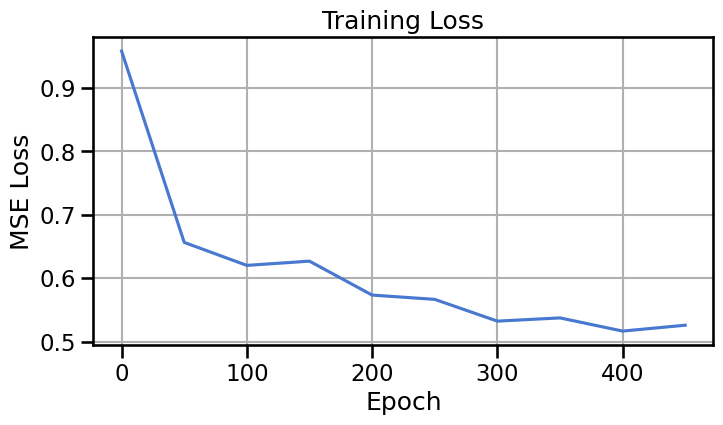

In [7]:
#| code-fold: false
class DiffusionModel(nn.Module):
    def __init__(self, n_steps=200, time_emb_dim=16, hidden_dim=128):
        super().__init__()
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(2 + time_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2) # Predicts the noise
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        x_in = torch.cat([x, t_emb], dim=-1)
        return self.net(x_in)

# Training parameters
T = 200 # Number of diffusion steps
lr = 1e-3
n_epochs = 500
batch_size = 256

# Data
data, _ = create_ring_gaussians(n_samples=10000)
loader = make_loader(data, batch_size=batch_size)

# Model and optimizer
model = DiffusionModel(n_steps=T).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
alphas, alphas_cumprod = get_alphas(timesteps=T)

# Training loop
losses = []
for epoch in range(n_epochs):
    for (x_0,) in loader:
        x_0 = x_0.to(device)
        
        # 1. Sample a random time t
        t = torch.randint(0, T, (x_0.shape[0],), device=device).long()
        
        # 2. Create noisy sample x_t and get the true noise
        x_t, noise = forward_diffusion_sample(x_0, t, alphas_cumprod, device)
        
        # 3. Predict the noise
        predicted_noise = model(x_t, t)
        
        # 4. Calculate the loss
        loss = nn.functional.mse_loss(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        losses.append(loss.item())
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Training complete.")

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(0, n_epochs, 50), losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

## Generating Samples via Reverse Sampling

With our time-conditional noise predictor $\epsilon_\theta(x_t, t)$ fully trained, we can now perform the reverse process to generate new data. This is the most intuitive and visually satisfying part of diffusion models.

We start with pure Gaussian noise, $x_T \sim \mathcal{N}(0, I)$, and then iteratively "denoise" it by stepping backward in time from $t=T-1$ down to $t=0$. Each reverse step updates the sample's position based on the predicted noise (which is related to the score as we saw above).

The update rule for a single reverse step (from $t$ to $t-1$) is:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z
$$

where $z \sim \mathcal{N}(0, I)$ is new noise added at each step (for a stochastic sampler), and $\sigma_t$ is its standard deviation. This equation looks complex, but the intuition is simple:

1.  **Predict Noise:** Use the network $\epsilon_\theta(x_t, t)$ to estimate the noise that was added to get to the current state $x_t$.
2.  **Estimate Clean Data:** Use the predicted noise to get a rough estimate of the original clean data, $x_0$.
3.  **Step Back:** Use this estimate to take one step backward in the diffusion process, arriving at a slightly less noisy sample, $x_{t-1}$.
4.  **Add Stochasticity:** Add a small amount of random noise to explore the distribution (this corresponds to the SDE sampler). If we omit this term, we get a deterministic sampler (an ODE).

Let's implement this reverse sampling process and watch as a cloud of random noise transforms into our target ring of Gaussians. This animation is the core "aha" moment for understanding how diffusion models work.

In [8]:
#| code-fold: false
@torch.no_grad()
def reverse_sample(model, n_samples=50, n_steps=20, initial_noise_scale=1.0):
    """Generate samples by running the reverse diffusion process."""
    model.eval()
    
    # Start with pure noise
    x = torch.randn(n_samples, 2, device=device) * initial_noise_scale
    
    # Store trajectory for animation
    trajectory = [x.cpu().numpy()]
    
    # Get noise schedule
    alphas, alphas_cumprod = get_alphas(timesteps=n_steps)
    betas = 1. - alphas
    
    for i in range(n_steps - 1, -1, -1):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t)
        
        # Get parameters for this timestep
        alpha_t = alphas[t][:, None]
        alpha_t_cumprod = alphas_cumprod[t][:, None]
        beta_t = betas[t][:, None]
        
        # The update rule
        coeff = (1. - alpha_t) / torch.sqrt(1. - alpha_t_cumprod)
        x = (1. / torch.sqrt(alpha_t)) * (x - coeff * predicted_noise)
        
        if i > 0:
            # Add noise for stochastic sampling
            variance = beta_t
            noise = torch.randn_like(x) * torch.sqrt(variance)
            x = x + noise
            
        trajectory.append(x.cpu().numpy())
        
    return x.cpu().numpy(), np.array(trajectory)

# Generate samples and their trajectories
num_generated_samples = 5000
generated_samples, trajectory = reverse_sample(model, 
                                               n_samples=num_generated_samples,
                                               n_steps=T)

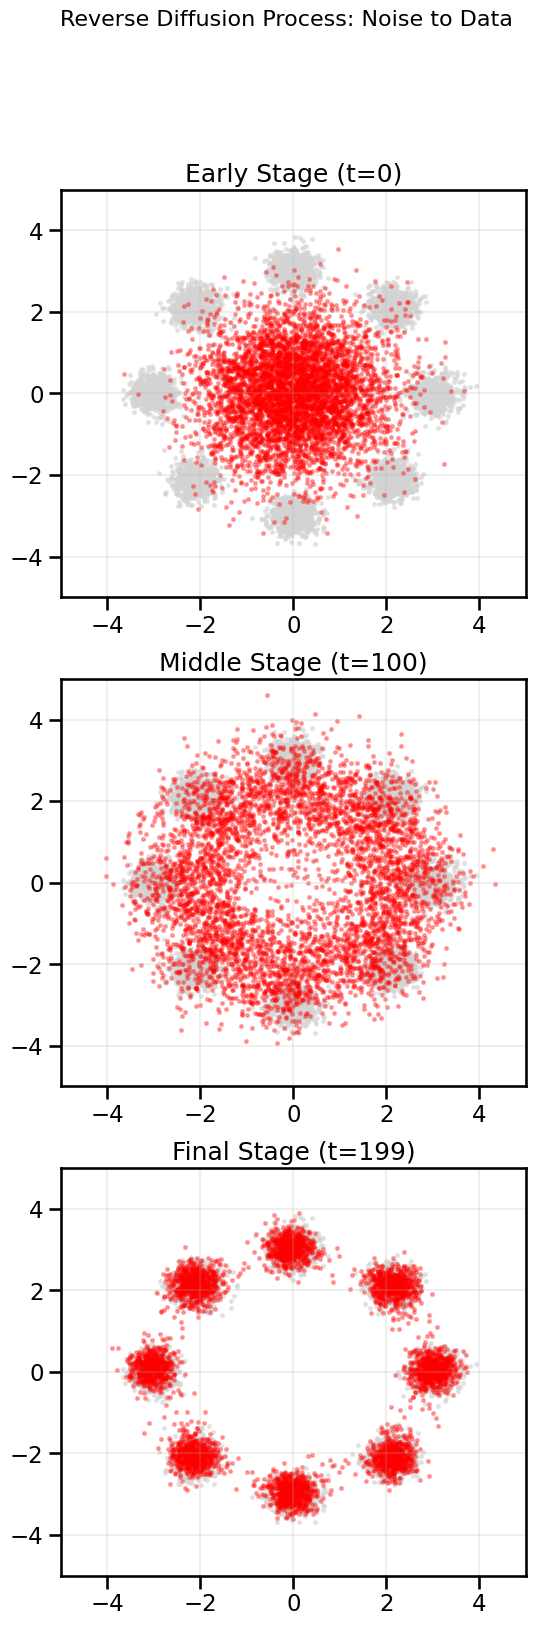

In [9]:
# Pick a random subset of the original data for background visualization
data_indices = np.random.choice(data.shape[0], size=num_generated_samples, replace=False)
data_subset = data[data_indices]

# Show samples at three different stages of diffusion: early, middle, and at the end:
fig, axes = plt.subplots(3, 1, figsize=(6,18))
stages = [0, T//2, T-1]
stage_titles = ['Early Stage (t=0)', 'Middle Stage (t=100)', 'Final Stage (t=199)']
for ax, stage, title in zip(axes, stages, stage_titles):
    ax.scatter(data_subset[:, 0], data_subset[:, 1], s=5, color='lightgrey', alpha=0.5)
    ax.scatter(trajectory[stage][:, 0], trajectory[stage][:, 1], s=5, color="red", alpha=0.3)
    ax.set_title(title)
    #ax.axis('equal')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.grid(True, alpha=0.2)
fig.suptitle("Reverse Diffusion Process: Noise to Data", fontsize=16)
plt.show()


We can also animate the entire reverse diffusion process to visualize how samples evolve from pure noise to structured data:

In [10]:

fig, ax = plt.subplots(figsize=(8, 8))

def update(frame):
    ax.clear()
    
    # Plot the target distribution in the background
    #sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="viridis", fill=True, alpha=0.3, ax=ax, levels=15)
    
    # Plot the current state of the samples
    current_samples = trajectory[frame]

    # Plot the original data samples for comparison
    ax.scatter(data_subset[:, 0], data_subset[:, 1], s=5, color='lightgrey', alpha=0.5)

    ax.scatter(current_samples[:, 0], current_samples[:, 1], s=10, color='red', alpha=0.05)
    
    ax.set_title(f"Reverse Diffusion: Step {T - frame}/{T}")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.grid(True, alpha=0.2)

# Create and display the animation
# The number of frames is the number of steps in the trajectory
# We can skip frames to make the animation faster
skip_frames = 5
frames = range(0, trajectory.shape[0], skip_frames)
ani = FuncAnimation(fig, update, frames=frames, repeat=False, interval=50)
plt.close(fig) # Prevent static plot from showing
HTML(ani.to_jshtml())

The animation illustrates the generative process: the points start as a random cloud and are gradually "guided" by the learned, time-varying score field. As time decreases, the field becomes sharper, pulling the points onto the intricate structure of original data distribution.

## Connection to Langevin Dynamics

How does this relate to the Langevin Dynamics we used in the previous chapter?

You can think of the reverse diffusion process as a more sophisticated, "annealed" version of Langevin Dynamics.

-   **Langevin Dynamics** (or at least how we used it in the last chapter) operates on a single, fixed energy landscape (defined by $\log p(x)$). It explores this landscape locally and is dependent on a single noise level applied to the score function.
-   **Reverse Diffusion** operates on a changing landscape. It starts on a very smooth, simple landscape (at high $t$) where the global structure is easy to find. As $t$ decreases, the landscape becomes more detailed, allowing the sampler to refine the samples it generates.

At $t \approx 0$, the reverse SDE step is mathematically very similar to a Langevin dynamics step on the true data score. So, diffusion models can be seen as a way to reliably initialize a sampler in a high-density region before switching to local exploration. This is why they are so effective at generating high-quality, diverse samples.

## Summary and Next Steps

-   **Diffusion Models as Time-Extended Score Models:** Diffusion models solve the problems of single-noise score matching by learning a score function across a continuum of noise levels.
-   **Forward Process:** Data is gradually noised into an isotropic Gaussian distribution, creating a series of well-behaved intermediate distributions $p_t(x)$.
-   **Reverse Process:** A time-conditional neural network, $\epsilon_\theta(x_t, t)$, learns to predict the noise at any given time $t$. This network is trained with a simple MSE loss.
-   **Generative Sampling:** By starting with pure noise and running the process in reverse, we can iteratively denoise the samples, guiding them onto the data manifold to produce realistic new data.

This notebook provided an intuitive, 2D look at how diffusion models work. In practice, these same principles are applied to generate high-resolution images, audio, and other complex data, often using more sophisticated network architectures like U-Nets. The core concepts of the forward and reverse processes, however, remain exactly the same.